# Проект 7. Приоритезация гипотез и анализ А/В-теста 

## Введение

### Описание проекта 

Для крупного интернет-магазина вместе с отделом маркетинга был подготовлен список гипотез для увеличения выручки.<br>
Необходимо приоритезировать гипотезы, запустить A/B-тест и проанализовать результаты. <br>
Проект будет состоять из 2х частей.

### Описание данных 

Данные для части 1.<br>
Файл /datasets/hypothesis.csv. Содержит 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.<br>
•	Hypothesis — краткое описание гипотезы;<br>
•	Reach — охват пользователей по 10-балльной шкале;<br>
•	Impact — влияние на пользователей по 10-балльной шкале;<br>
•	Confidence — уверенность в гипотезе по 10-балльной шкале;<br>
•	Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.<br>

Данные для части 2.<br>
После проведения A/B-теста получили результаты, которые описаны в следующих файлах:<br>
Файл /datasets/orders.csv. <br>
•	transactionId — идентификатор заказа;<br>
•	visitorId — идентификатор пользователя, совершившего заказ;<br>
•	date — дата, когда был совершён заказ;<br>
•	revenue — выручка заказа;<br>
•	group — группа A/B-теста, в которую попал заказ.<br>
Файл /datasets/visitors.csv. <br>
•	date — дата;<br>
•	group — группа A/B-теста;<br>
•	visitors — количество пользователей в указанную дату в указанной группе A/B-теста<br>


### План исследования 

Часть 1. Приоритизация гипотез.<br>
- [1.0 Загрузка данных и подготовка их к анализу](#prepare_1) 
- [1.1 Применение фреймворка ICE для приоритезации гипотез](#ICE)
- [1.2 Применение фреймворка RICE для приоритезации гипотез](#RICE)
- [1.3 Сравнение ICE и RICE](#vs)
<br>

Часть 2. Анализ A/B-теста.<br>

- [2.0 Загрузка данных и подготовка их к анализу](#prepare_2)
- [2.1 Анализ кумулятивной выручки по группам](#кум_выручка) <br>
- [2.2 Анализ кумулятивного среднего чека по группам](#кум_средн_чек) <br>
- [2.3 Анализ относительного изменения кумулятивного среднего чека группы B к группе A](#отн_изм_средн_чека) <br>
- [2.4 Анализ кумулятивной конверсии по группам](#кум_конверсия) <br>
- [2.5 Анализ относительного изменения кумулятивной конверсии группы B к группе A](#отн_изм_конверсии) <br>
- [2.6 Анализ количества заказов по пользователям](#количество_заказов) <br>
- [2.7 Определение выбросов и всплесков в количестве заказов на пользователя. Выбор границы для определения аномальных пользователей](#выбросы_в_заказах_граница)<br>
- [2.8 Анализ стоимостей заказов](#стоимость_заказов) <br>
- [2.9 Определение выбросов и всплесков в стоимости заказов. Выбор границы для определения аномальных заказов](#выбросы_в_стоимостях_граница)<br>
- [2.10 Расчет статистической значимости различий в конверсии между группами по «сырым» данным](#сырые_стат_знач_конверсия)<br>
- [2.11 Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным](#сырые_стат_знач_средн_чек) <br>
- [2.12 Расчет статистической значимости различий в конверсии между группами по «очищенным» данным](#очищенные_стат_знач_конверсия) <br>
- [2.13 Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным](#очищенные_стат_знач_средн_чек) <br>
- [2.14 Принятие решения по результатам теста](#решение_по_рез_теста) 

Часть 3. [Общий вывод](#conclusions)<br>

## Часть 1.  Приоретизация гипотез

### 1.0 Загрузка данных и предобработка <a id='prepare_1'></a>

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy import stats as st
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

from IPython.display import display
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 


In [2]:
hypothesis  = pd.read_csv('/datasets/hypothesis.csv') 
pd.set_option('display.max_columns', None)   # устанавливаем параметр, чтобы показывать содержание ячейки полностью
pd.options.display.max_colwidth = 150        # устанавливаем максимальную ширину колонки
display(hypothesis)
hypothesis.info()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [3]:
hypothesis.describe()

,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


Пропусков в данных нет. Шкала параметров от 1 до 10.

Отформатируем названия столбцов.

In [4]:
hypothesis.columns=hypothesis.columns.str.lower()
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

### 1.1  Применение фреймворка ICE для приоритезации гипотез <a id='ICE'></a>

Приоритезируем гипотезы по методу `ICE`.

In [5]:
hypothesis['ICE']=((hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts'])
display(hypothesis.sort_values(by='ICE',ascending = False).style.format({'ICE':'{:.1f}'}))

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0


В первую четверку ***самых перспективных гипотез по методу `ICE`*** вошли гипотезы ***под следующими номерами номерами (в порядке убывания приоритета)***:
- ***№8*** "Запустить акцию, дающую скидку на товар в день рождения", 
- ***№0*** "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",
- ***№7*** "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",
- ***№6*** "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию".
<br>

### 1.2 Применение фреймворка RICE для приоритезации гипотез <a id='RICE'></a>

Приоритезируем гипотезы по методу `RICE`.

In [6]:
hypothesis['RICE']=(hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
display(hypothesis.sort_values(by='RICE',ascending = False).style.format({'ICE':'{:.1f}', 'RICE':'{:.1f}'}))

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


***По методу `RICE` самыми приоритетными гипотезами*** будут гипотезы ***под следующими номерами номерами (в порядке убывания приоритета)***:

   - ***№7*** "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",
   - ***№2*** "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",
   - ***№0*** "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",
   - ***№6*** "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию".
<br>

### 1.3 Сравнение ICE и RICE <a id='vs'></a>

 Сравним результаты двух методов.

Как мы видим, ***в первую четверку по методу `RICE` по-прежнему входят все те же гипотезы №7*** "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок", ***№0*** "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей", ***и №6*** "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию", ***а занимавшую первое место в методе `ICE` гипотезу №8*** "Запустить акцию, дающую скидку на товар в день рождения" ***вытеснила на пятое место гипотеза №2***  "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа". ***Так получилось потому, что в методе `RICE` дополнительно учитывается в числителе показатель охвата `reach`, который у гипотезы №8 - минимальный среди всех гипотез (`reach` = 1), а у гипотезы №2 он достаточно велик  (`reach` = 8)***. И , действительно, при запуске акции, дающей скидку на товар в день рождения  данная акция охватит лишь небольшой процент пользователей, у которых будет день рождения в период проведения акции. В отличие от  добавления блоков рекомендаций товаров на сайт интернет-магазина, которые будут видеть от 80 до 100% пользователей (в зависимости от раздела или этапа заказа, в/на котором будет размещены данные блоки).<br>
По этой же причине гипотеза №7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" поднялась с третьего место  на первое: у нее максимальный показатель охвата (`reach` = 10).<br>
Итак, ***по методу `RICE`***, который наряду с показателями метода `ICE` учитывает также важный  показатель охвата (то есть показатель, учитывающий, насколько широкую аудиторию потенциальных клинтов затронет применение конкретной гипотезы), ***побеждает гипотеза №7 'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок'***, как гипотеза с максимальным показателем охвата, достаточно высокими показателями влияния и уверенности, и относительно небольшими усилиями на ее реализацию.

## Часть 2.  Анализ результатов A/B-теста

### 2.0 Загрузка данных и подготовка их к анализу <a id='prepare_2'></a>

In [7]:
#orders  = pd.read_csv('orders.csv') # для работы на локальном диске
orders  = pd.read_csv('/datasets/orders.csv') # для работы в облаке
display(orders.head())
orders.info()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
#visitors  = pd.read_csv('visitors.csv')  # для работы на локальном диске
visitors  = pd.read_csv('/datasets/visitors.csv') # для работы в облаке
display(visitors.head())
visitors.info()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [9]:
orders.duplicated().sum()

0

In [10]:
visitors.duplicated().sum()

0

Пропусков и полных дубликатов нет.

Приведем столбцы с датой к формату 'datetime'.

In [11]:
#orders['date'] = pd.to_datetime(orders['date'], format = '%Y-%m-%d')
#visitors['date'] = pd.to_datetime(visitors['date'], format = '%Y-%m-%d')
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders.info()
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Проверим, что проведенный А/В - тест удовлетворял условию на равенство количества посетителей в обеих группах.

In [12]:
# считаем посетителей в группе А:
count_visitors_in_A = visitors[visitors['group']=='A']['visitors'].sum()
count_visitors_in_A

18736

In [13]:
# считаем посетителей в группе В:
count_visitors_in_B = visitors[visitors['group']=='B']['visitors'].sum()
count_visitors_in_B

18916

In [14]:
print("Разница в количестве посетителей в разных группах теста: {0:.1%}".format( (count_visitors_in_B - count_visitors_in_A)/count_visitors_in_A))

Разница в количестве посетителей в разных группах теста: 1.0%


Разница количества посетителей между группами не превышает допустимый 1%. Все хорошо.

In [15]:
#orders['date'].describe()

In [16]:
#visitors['date'].describe()

## Исследовательский анализ данных

### 2.1 Анализ кумулятивной выручки по группам. <a id='кум_выручка'></a>

In [17]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()
datesGroups.head(4)

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B


In [18]:
# получаем агрегированные кумулятивные по дням данные о заказах: построчно применяем функцию "лямбда" к datesGroups  
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 
          'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

ordersAggregated.head(2)

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217


In [19]:
# получаем агрегированные кумулятивные по дням данные о посетителях: построчно применяем функцию "лямбда" к datesGroups 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

display(visitorsAggregated.head(2))

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713


In [20]:
# объединяем кумулятивные данные в одной таблице, переименовываем некоторые столбцы
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData = cumulativeData.rename(columns = {'transactionId':'orders', 'visitorId':'buyers'})

display(cumulativeData.head(3))

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338


In [21]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

display(cumulativeRevenueA.head(1))
display(cumulativeRevenueB.head(1))

,date,revenue,orders
0,2019-08-01,148579,24


,date,revenue,orders
1,2019-08-01,101217,21


Наконец, построим графики кумулятивной выручки по группам теста.

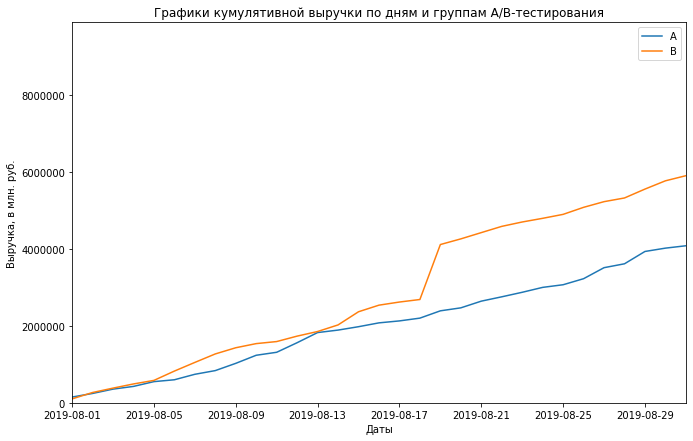

In [22]:
plt.figure(figsize = (11,7))
plt.title("Графики кумулятивной выручки по дням и группам A/B-тестирования")
plt.xlabel("Даты")
plt.ylabel("Выручка, в млн. руб.")

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A');

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B');

plt.legend();

plt.axis([cumulativeRevenueA['date'].min(), cumulativeRevenueA['date'].max(), 0, 9900000]);

Выручка почти равномерно увеличивается в течение всего теста. Это хороший знак. ***График кумулятивной выручки группы В с первых дней теста лучше графика для группы А***. Однако, примерно ***в середине проведения теста график группы В резко скакнул вверх: это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке*** (это мы проанализируем позже). Заметим, что до конца проведения теста это увеличившееся различие в кумулятивных выручках стабильно сохранялось. То есть после скачка вверх, вероятно, не было серии аномально низких заказов, чтобы слегка сгладить это увеличившееся различие в группах.

### 2.2 Анализ кумулятивного среднего чека по группам <a id='кум_средн_чек'></a>

Построим графики кумулятивного среднего чека по группам — отношение кумулятивной выручки к кумулятивному числу заказов.


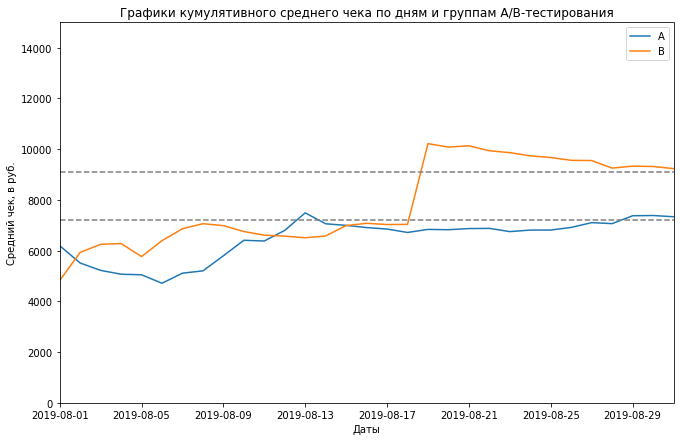

In [23]:
plt.figure(figsize = (11,7))
plt.title("Графики кумулятивного среднего чека по дням и группам A/B-тестирования")
plt.xlabel("Даты")
plt.ylabel("Средний чек, в руб.")

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend();

plt.axis([cumulativeRevenueA['date'].min(), cumulativeRevenueA['date'].max(), 0, 15000]);
plt.axhline(y=7200, color='grey', linestyle='--');
plt.axhline(y=9100, color='grey', linestyle='--');

Средний чек становится равномерным ближе к концу  теста. В начале теста группы несколько раз "обгоняют друг друга", но дальше группа В вырывается вперед и фиксирует свое лидерство. Аналогично графику выручки здесь также виден ***резкий  скачок среднего чека группы В в середине теста: скорее всего, это аномально крупные заказы в группе B, либо же всплеск заказов  середине теста***. В пользу этого говорит снижающийся тренд графика группы В после резкого скачка - данные постепенно приходят к норме. Тогда этой группе нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне. <br>
Значение среднего чека группы А с 14 августа установилось примерно на уровне 7200 р.  Значение среднего чека группы B установилось примерно на уровне 9100 лишь в последние 4 дня. Возможно, целесообразно продолжить тест еще некоторое время.

### 2.3 Анализ относительного изменения кумулятивного среднего чека по группам <a id='отн_изм_средн_чека'></a>

Построим график относительного различия для среднего чека.

In [24]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', 
                                                   right_on='date', how='left', suffixes=['A', 'B'])
mergedCumulativeRevenue.head(2)

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45


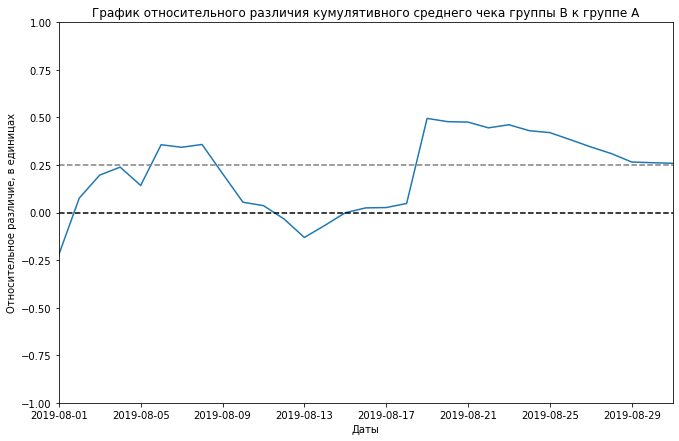

In [25]:
plt.figure(figsize = (11,7))
plt.title("График относительного различия кумулятивного среднего чека группы B к группе A")
plt.xlabel("Даты")
plt.ylabel("Относительное различие, в единицах")

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/          \
        (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');
plt.axis([mergedCumulativeRevenue['date'].min(), mergedCumulativeRevenue['date'].max(), -1, 1]);
plt.axhline(y=0.25, color='grey', linestyle='--');

Примерно с середины теста ***группа В уверенно занимает лидирующее положение и закрепляется на нем (плато последние 4 дня)***.<br>
В нескольких точках график различия между группами резко "скачет". ***Очередное подозрение в наличии крупных заказов и/или их всплесков***. 

### 2.4 Анализ кумулятивной конверсии по группам <a id='кум_конверсия'></a>

Проанализируем график кумулятивной конверсии.

In [26]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

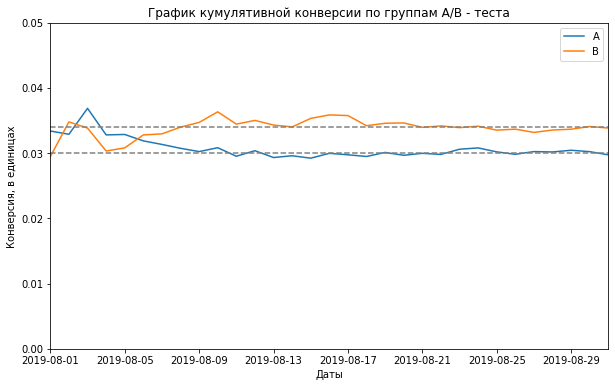

In [27]:
plt.figure(figsize = (10,6))
plt.title("График кумулятивной конверсии по группам A/В - теста")
plt.xlabel("Даты")
plt.ylabel("Конверсия, в единицах")

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend();

#cumulativeDataA.info()
#cumulativeDataB.info()
# задаем масштаб осей
plt.axis([cumulativeDataA['date'].min(), cumulativeDataA['date'].max(), 0, 0.05]);
#plt.axis(['2019-08-01', '2019-08-31', 0, 0.05])
plt.axhline(y=0.03, color='grey', linestyle='--');
plt.axhline(y=0.034, color='grey', linestyle='--');

В начале группа А была лучше по конверсии, но примерно через неделю от начала теста ***группа В вырвалась вперед и уверенно зафиксировалась на первом месте***. Интересно, что это произошло гораздо раньше, чем зафиксированы всплески по выручке и среднему чеку.<br>
Кумулятивная конверсия группы А - примерно 3%, группы В - в районе 3,4%.  

### 2.5 Анализ относительного изменения кумулятивной конверсии  по группам <a id='отн_изм_конверсии'></a>

Объединим данные по конверсиям групп и построим график их относительного изменения.

In [28]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']]    \
                                .merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', 
                               how='left', suffixes=['A', 'B'])
    
mergedCumulativeConversions.head(3)

,date,conversionA,conversionB
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833


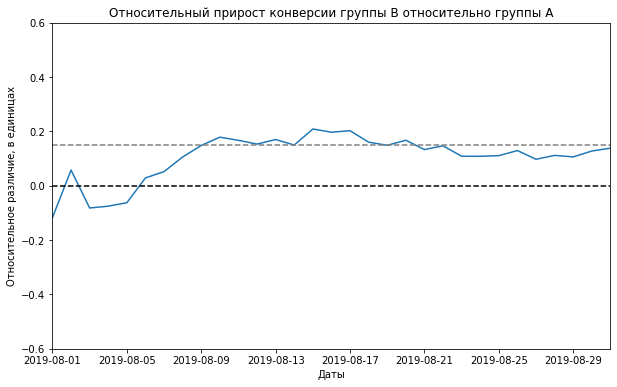

In [29]:
plt.figure(figsize = (10,6))
plt.title("Относительный прирост конверсии группы B относительно группы A")
plt.xlabel("Даты")
plt.ylabel("Относительное различие, в единицах")

plt.plot(mergedCumulativeConversions['date'],
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--');
plt.axhline(y=0.15, color='grey', linestyle='--');
plt.axis([ mergedCumulativeConversions['date'].min(), mergedCumulativeConversions['date'].max(), -0.6, 0.6]);
#plt.axis(["2019-04-01", '2019-04-23', -0.7, 0.7])

После недели проведения теста ***группа В стала явно "лучше" группы А: её превышение кумулятивной конверсии***  колебалось в течение оставшихся трех недель теста примерно между 10% и 20%, и к концу теста ***установилось примерно на 15%***.<br> Однако, прежде, чем делать выводы, необходимо проанализировать аномалии.<br>

Перейдем к анализу выбросов и всплесков. 

### 2.6 Количество заказов по пользователям <a id='количество_заказов'></a>

 Найдем количество заказов для каждого пользователя.

In [30]:
ordersByUsers = orders.groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
# второй способ:
#ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsers = ordersByUsers.rename(columns = {'transactionId':'orders'})
print("Количество пользователей:", ordersByUsers.shape[0])
display(ordersByUsers.sort_values(by='orders',ascending=False).head(10))

Количество пользователей: 1031


,visitorId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


Создадим объект Series с порядковыми номерами покупателей.

In [31]:
x_values_1 = pd.Series(range(0, len(ordersByUsers)))
x_values_1.tail(3)

1028    1028
1029    1029
1030    1030
dtype: int64

Построим точечный график количества заказов по покупателям. 

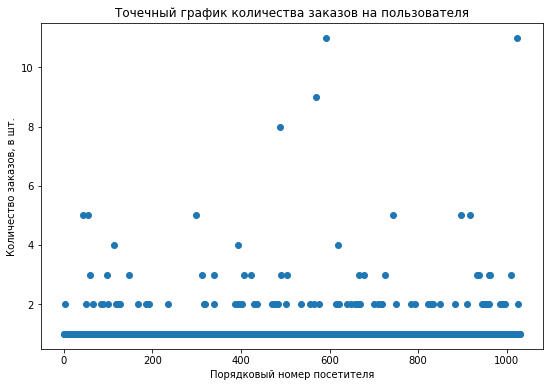

In [32]:
plt.figure(figsize = (9,6))
plt.title("Точечный график количества заказов на пользователя")
plt.xlabel("Порядковый номер посетителя")
plt.ylabel("Количество заказов, в шт.")

plt.scatter(x_values_1, ordersByUsers['orders'] );

Как мы и предполагали - есть много пользователей с 2-3 заказами, а также же неколько пользователей с заказами от 4 до 11). Их доля точно неясна: непонятно, считать ли их аномалиями.<br>

### 2.7 Оценка крайних значений данных по количеству заказов. Выбор границы для определения аномалий  <a id='выбросы_в_заказах_граница'></a>

Оценим выборочные перцентили количества заказов на пользователя -от 95% до 99%.

In [33]:
percentiles_orders_count = np.percentile(ordersByUsers['orders'],[95, 96, 97, 98, 99])
print(percentiles_orders_count)

[2. 2. 2. 3. 4.]


In [34]:
print("{0:.1%}".format(ordersByUsers[ordersByUsers['orders']> 2]['visitorId'].count()/ ordersByUsers.shape[0]))

2.9%


***95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказа*** на пользователя соответственно. 3% пользователей совершают более 2-х заказов, и 1% пользователей - от 4х заказов. <br>
Пользователи, совершившие много заказов, влияют на числитель формулы конверсии. Скорее всего, их поведение отличается от нормального. Если речь не идёт об интернет-магазине с регулярным спросом, «обычный» пользователь совершает не больше двух заказов за короткий срок. <br> Поэтому ***для определения выбросов возьмем границу в 2 заказа  - так мы отсечем 3% пользователей, совершающих более 2х заказов***.

### 2.8 Построение графика стоимостей заказов <a id='стоимость_заказов'></a>

Построим точечный график стоимостей заказов.

In [35]:
x_values_2 = pd.Series(range(0,len(orders)))
x_values_2.tail(3)

1194    1194
1195    1195
1196    1196
dtype: int64

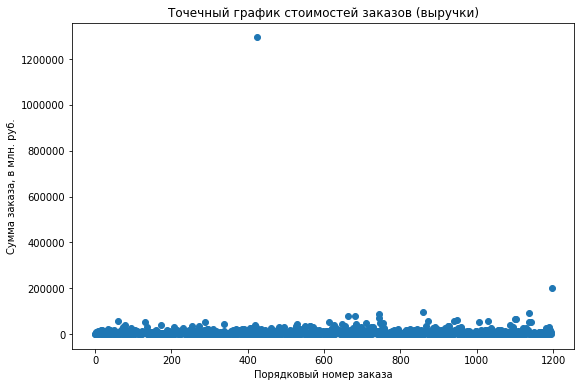

In [36]:
plt.figure(figsize = (9,6))
plt.title("Точечный график стоимостей заказов (выручки)")
plt.xlabel("Порядковый номер заказа")
plt.ylabel("Сумма заказа, в млн. руб.")

plt.scatter(x_values_2, orders['revenue']);

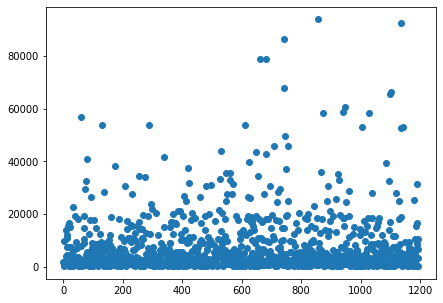

In [37]:
#посмотрим как распределена выручка от заказа в пределах 100 000р.
plt.figure(figsize = (7,5))
plt.scatter(pd.Series(range(0,orders.query('revenue<100000').shape[0])),orders.query('revenue<100000')['revenue']);

Как и предполагалось - есть два громадных по стоимости заказа - на 200 тыс.р. и даже на 1,3 млн.руб.! И много заказов от 20 000р. до 100 000р.<br>

### 2.9 Определение выбросов и всплесков в стоимости заказов. Выбор границы для определения аномальных заказов  <a id='выбросы_в_стоимостях_граница'></a>

Определим перцентили среднего чека в выборке.

In [38]:
percentiles_revenue = np.percentile(orders['revenue'], [95, 96, 97, 98, 99])
print(percentiles_revenue)

[28000.  31382.  35485.  44133.2 58233.2]


***5% пользователей совершают заказы стоимостью свыше 28000 р., и 1% пользователей - свыше 58233 р***. <br>
***Для определения выбросов возьмем границу в 40000 р. - так мы отсечем от 2% до 3% пользователей, совершающих дорогие заказы.***

### 2.10 Оценка различий в конверсии между группами по «сырым» данным <a id='сырые_стат_знач_конверсия'></a>

Посчитаем статистическую значимость различий в конверсии между группами теста по «сырым» данным — без удаления аномальных пользователей.<br>
Подготовим данные к анализу.<br>

In [39]:
# количество пользователей в группе А на определенную дату
visitorsADaily = visitors[visitors['group']=='A'][['date','visitors']]
visitorsADaily  = visitorsADaily.rename(columns = {'visitors':'visitorsPerDateA'})
visitorsADaily.head(3)

,date,visitorsPerDateA
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507


In [40]:
# количество пользователей нарастающим итогом (кумулятивное) в группе А на определенную дату
visitorsACummulative = visitorsADaily.apply(
                       lambda x:  visitorsADaily[visitorsADaily['date'] <= x['date']]  \
                        .agg({'date':'max', 'visitorsPerDateA':'sum'}) ,axis = 1)
visitorsACummulative = visitorsACummulative.rename(columns = {'visitorsPerDateA':'visitorsCummulativeA'})
visitorsACummulative.head(3)

,date,visitorsCummulativeA
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845


In [41]:
# количество пользователей в группе В на определенную дату
visitorsBDaily = visitors[visitors['group']=='B'][['date','visitors']]
visitorsBDaily  = visitorsBDaily.rename(columns = {'visitors':'visitorsPerDateB'})
visitorsBDaily.head(3)

,date,visitorsPerDateB
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509


In [42]:
# количество пользователей нарастающим итогом (кумулятивное) в группе B на определенную дату
visitorsBCummulative = visitorsBDaily.apply(
                       lambda x:  visitorsBDaily[visitorsBDaily['date'] <= x['date']]  \
                        .agg({'date':'max', 'visitorsPerDateB':'sum'}) ,axis = 1)
visitorsBCummulative = visitorsBCummulative.rename(columns = {'visitorsPerDateB':'visitorsCummulativeB'})
visitorsBCummulative.head(3)

,date,visitorsCummulativeB
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803


In [43]:
# количество заказов и сумма выручки в группе А на определенную дату
ordersADaily = orders[orders['group']=='A'].groupby('date', as_index = False)     \
                        .agg({'transactionId': pd.Series.nunique, 'revenue':'sum'})
ordersADaily = ordersADaily.rename(columns = {'transactionId':'ordersPerDateA', 'revenue':'revenuePerDateA'})
ordersADaily.head(2)

,date,ordersPerDateA,revenuePerDateA
0,2019-08-01,24,148579
1,2019-08-02,20,93822


In [44]:
# количество заказов и сумма выручки нарастающим итогом (кумулятивные) в группе А на определенную дату
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']]   \
                 .agg({'date':'max', 
                       'ordersPerDateA':'sum',
                       'revenuePerDateA':'sum'}) ,
    axis = 1).sort_values(by = 'date')  # сортировка не обязательна, и так выдает по порядку дат
# axis = 1 - применяем функцию лямбда построчно к DF "ordersADaily"
ordersACummulative = ordersACummulative.rename(columns = {'ordersPerDateA':'ordersCummulativeA',
                                                          'revenuePerDateA':'revenueCummulativeA'})
ordersACummulative.head(3)

,date,ordersCummulativeA,revenueCummulativeA
0,2019-08-01,24,148579
1,2019-08-02,44,242401
2,2019-08-03,68,354874


In [45]:
# количество заказов и сумма выручки в группе В на определенную дату
ordersBDaily = orders[orders['group']=='B'].groupby('date', as_index = False)     \
                        .agg({'transactionId': pd.Series.nunique, 'revenue':'sum'})
ordersBDaily = ordersBDaily.rename(columns = {'transactionId':'ordersPerDateB', 'revenue':'revenuePerDateB'})
ordersBDaily.head(3)

,date,ordersPerDateB,revenuePerDateB
0,2019-08-01,21,101217
1,2019-08-02,24,165531
2,2019-08-03,16,114248


In [46]:
# количество заказов и сумма выручки нарастающим итогом (кумулятивные) в группе В на определенную дату
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']]   \
                 .agg({'date':'max', 
                       'ordersPerDateB':'sum',
                       'revenuePerDateB':'sum'}) ,
    axis = 1).sort_values(by = 'date')  # сортировка не обязательна, и так выдает по порядку дат
# axis = 1 - применяем функцию лямбда построчно к DF "ordersBDaily"
ordersBCummulative = ordersBCummulative.rename(columns = {'ordersPerDateB':'ordersCummulativeB',
                                                          'revenuePerDateB':'revenueCummulativeB'})
ordersBCummulative.head(3)

,date,ordersCummulativeB,revenueCummulativeB
0,2019-08-01,21,101217
1,2019-08-02,45,266748
2,2019-08-03,61,380996


Объединим все полученные датасеты в один.

In [47]:
data = (ordersADaily.merge(ordersBDaily, on = 'date', how = 'left')     
                   .merge(ordersACummulative, on = 'date', how = 'left')  
                   .merge(ordersBCummulative, on = 'date', how = 'left') 
                   .merge(visitorsADaily, on = 'date', how = 'left')  
                   .merge(visitorsBDaily, on = 'date', how = 'left')  
                   .merge(visitorsACummulative, on = 'date', how = 'left')  
                   .merge(visitorsBCummulative, on = 'date', how = 'left')  )
data.head(3)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803


Создадим два датасета - для группы А и для группы В.  В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [48]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index = False)   \
                                             .agg({'transactionId':pd.Series.nunique})
ordersByUsersA = ordersByUsersA.rename(columns = {'transactionId':'orders'})
ordersByUsersA.tail(3)

,visitorId,orders
500,4259830713,1
501,4266935830,1
502,4278982564,1


In [49]:
ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index = False)   \
                                             .agg({'transactionId':pd.Series.nunique})
ordersByUsersB = ordersByUsersB.rename(columns = {'transactionId':'orders'})
ordersByUsersB.tail(3)

,visitorId,orders
583,4279090005,1
584,4281247801,1
585,4283872382,1


Объявим переменные `sampleA` и `sampleB`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это вспомогательный этап для подготовки выборок к проверке статистическим U-критерием Манна-Уитни.

Переменная `sampleA` должна состоять из двух частей:
-   Список с количеством заказов для каждого из пользователей: `ordersByUsersA['orders']`.
-   Нули для пользователей, которые ничего не заказывали. Их количество равно разнице между суммой посетителей и количеством записей о заказах: `data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])`.

Создадим объект pd.Series нужной длины:

In [50]:
print("Посетителей в группе А:", data['visitorsPerDateA'].sum())
print("Покупателей в группе А:", len(ordersByUsersA['orders']))
print("Разница между кол-вом посетителей и покупателей в группе А:", 
      data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders']))
null_Series_A = pd.Series(0, np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), 
                          name = 'orders')
null_Series_A

Посетителей в группе А: 18736
Покупателей в группе А: 503
Разница между кол-вом посетителей и покупателей в группе А: 18233


0        0
1        0
2        0
3        0
4        0
        ..
18228    0
18229    0
18230    0
18231    0
18232    0
Name: orders, Length: 18233, dtype: int64

In [51]:
print("Посетителей в группе В:", data['visitorsPerDateB'].sum())
print("Покупателей в группе B:", len(ordersByUsersB['orders']))
print("Разница между кол-вом посетителей и покупателей в группе B:", 
      data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders']))
null_Series_B = pd.Series(0, np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), 
                          name = 'orders')
null_Series_B

Посетителей в группе В: 18916
Покупателей в группе B: 586
Разница между кол-вом посетителей и покупателей в группе B: 18330


0        0
1        0
2        0
3        0
4        0
        ..
18325    0
18326    0
18327    0
18328    0
18329    0
Name: orders, Length: 18330, dtype: int64

Объединим обе части в единую переменную - выборку `sampleA`. И тоже самое - для `sampleB`.

In [52]:
sampleA = pd.concat([ ordersByUsersA['orders'], null_Series_A ], axis = 0, ignore_index = True) 
                                                # соединяем вдоль строк  и переустанавливаем единые индексы
sampleB = pd.concat( [ ordersByUsersB['orders'], null_Series_B ], axis = 0, ignore_index = True)

display(ordersByUsersA['orders'])
display(sampleA)
display(ordersByUsersB['orders'])
display(sampleB)

0      1
1      1
2      1
3      1
4      1
      ..
498    1
499    7
500    1
501    1
502    1
Name: orders, Length: 503, dtype: int64

0        1
1        1
2        1
3        1
4        1
        ..
18731    0
18732    0
18733    0
18734    0
18735    0
Name: orders, Length: 18736, dtype: int64

0      1
1      1
2      1
3      1
4      1
      ..
581    1
582    1
583    1
584    1
585    1
Name: orders, Length: 586, dtype: int64

0        1
1        1
2        1
3        1
4        1
        ..
18911    0
18912    0
18913    0
18914    0
18915    0
Name: orders, Length: 18916, dtype: int64

Обычно, связанная с измеряемой социальной активностью величина распределена ненормально: отдельные пользователи могут совершать слишком большое количество действий относительно большинства, например, совершать очень много покупок в одном интернет-магазине за короткий срок, или же делать покупки на огромные суммы. Это выбросы, или аномалии. Такие выбросы могут сильно сдвигать результаты более точных (за счет работы со значениями) алгебраических (в том числе и параметрических) тестов. В таких случаях больше подходят непараметрические тесты: хоть они и  менее точные за счет работы с рангами значений, но зато они менее чувствительны к выбросам.<br>

Воспользуемся одним из таких тестов - статистическим U-критерием Манна-Уитни. Уровень статистической значимости определим как в 5%.

In [53]:
alpha = 0.05

raw_data_conversion = st.mannwhitneyu(sampleA, sampleB)
p_value = raw_data_conversion[1]
print("{0:.5f}".format(p_value))

if p_value < alpha:
    print("Отвергаем нулевую гипотезу. По «сырым» данным имеется статистически значимое различие в конверсии групп A и B.")
else:
    print("Не удалось отвергнуть нулевую гипотезу. По «сырым» данным различий в конверсии групп A и B нет.")

0.00840
Отвергаем нулевую гипотезу. По «сырым» данным имеется статистически значимое различие в конверсии групп A и B.


***Тест, проведенный по "сырым" (неочищенным от аномалий) данным показал***, что с заданным уровнем статистической значимости в 5% имеется ***статистически значимое различие в конверсии групп A и B***. Оценим это различие.<br>

Найдем относительный прирост конверсии группы B к конверсии группы А. 

Поскольку в `sampleA` - выборка, где каждый элемент — число заказов определённого пользователя, в том числе ноль. Значит, число элементов `sampleA` — это количество пользователей, сумма всех элементов — количество заказов. Чтобы получить конверсию в группе, поделим сумму заказов на число пользователей — найдём среднее в выборке `sampleA` методом `mean()`. Аналогично найдём конверсию группы B: `sampleB.mean()`. Относительный прирост конверсии группы : конверсия группы B / конверсия группы A - 1. <br>

In [54]:
print("{0:.1%}".format(sampleB.mean()/sampleA.mean() - 1))

13.8%


***Относительный прирост конверсии группы B к конверсии группы А составил почти 14%.***.

### 2.11 Оценка различий в среднем чеке между группами по «сырым» данным <a id='сырые_стат_знач_средн_чек'></a>

Посмотрим на  относительные различия в среднем чеке между группами. И посчитаем относительный прирост среднего чека группы B к среднему чеку группы А. 

In [55]:
alpha = 0.05

raw_data_average_check = st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])
p_value = raw_data_average_check.pvalue
print("{0:.5f}".format(p_value))

if p_value < alpha:
    print("Отвергаем нулевую гипотезу. По «сырым» данным имеется статистически значимое различие в срелнем чеке групп A и B.")
else:
    print("Не удалось отвергнуть нулевую гипотезу. По «сырым» данным различий в среднем чеке для групп A и B нет.")

0.36465
Не удалось отвергнуть нулевую гипотезу. По «сырым» данным различий в среднем чеке для групп A и B нет.


In [56]:
print("{0:.1%}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

25.9%


То есть ***по результатам теста по "сырым" данным причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия между группами , нет***.  Несмотря на то, что ***средний чек группы B почти на 26% выше среднего чека группы А***.

### 2.12 Оценка различий в конверсии между группами по «очищенным» данным <a id='очищенные_стат_знач_конверсия'></a>

Теперь сравним конверсии и средние чеки групп, но уже по очищенным от аномалий данным. <br>

Ранее мы определили, что аномально высокая стоимость чека - свыше 40 000р., и аномально большое количество заказов на пользователя - свыше 2х. Сделаем срезы пользователей с числом заказов больше 2х — `usersWithManyOrders` и пользователей, совершивших заказы дороже 40 000р. — `usersWithExpensiveOrders`. Объединим их в таблице `abnormalUsers`, удалим дубликаты, отсортируем. 

In [57]:
usersWithManyOrders = pd.concat( [ordersByUsersA[ordersByUsersA['orders']>2]['visitorId'],
                                    ordersByUsersB[ordersByUsersB['orders']>2]['visitorId']], axis = 0)
usersWithManyOrders.count()

24

In [58]:
usersWithExpensiveOrders = orders[orders['revenue'] > 40000]['visitorId']
usersWithExpensiveOrders.count()

29

In [59]:
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

1099    148427295
18      199603092
23      237748145
37      249864742
684     358944393
Name: visitorId, dtype: int64
(45,)


Получилось всего 45 аномальных пользователей.<br>

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим отфильтрованные выборки количества заказов по пользователям по группам теста.

In [60]:
#ordersByUsersA['visitorId'].isin(abnormalUsers).sum()

In [61]:
#ordersByUsersB['visitorId'].isin(abnormalUsers).sum()

In [62]:
sampleAFiltered = pd.concat(
    [ ordersByUsersA[~(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
      null_Series_A],
      axis=0, ignore_index = True ) # соединяем вдоль строк  и переустанавливаем единые индексы

""" знак отрицания ~ можно заменить на метод np.logical_not:
sampleAFiltered = pd.concat(
  [ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
   null_Series_A],
   axis=0)
"""
sampleBFiltered = pd.concat(
    [ ordersByUsersB[~(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],
      null_Series_B],
      axis=0, ignore_index = True ) # соединяем вдоль строк  и переустанавливаем единые индексы

display(ordersByUsersA[~(ordersByUsersA['visitorId'].isin(abnormalUsers))].reset_index()['orders'].tail())
display(sampleAFiltered)
display(ordersByUsersB[~(ordersByUsersB['visitorId'].isin(abnormalUsers))].reset_index()['orders'].tail())
display(sampleBFiltered)

464    1
465    1
466    1
467    1
468    1
Name: orders, dtype: int64

0        1
1        1
2        1
3        1
4        1
        ..
18697    0
18698    0
18699    0
18700    0
18701    0
Name: orders, Length: 18702, dtype: int64

555    1
556    1
557    1
558    1
559    1
Name: orders, dtype: int64

0        1
1        1
2        1
3        1
4        1
        ..
18885    0
18886    0
18887    0
18888    0
18889    0
Name: orders, Length: 18890, dtype: int64

Применим статистический критерий Манна-Уитни к полученным выборкам.

In [63]:
alpha = 0.05

filtered_data_conversion = st.mannwhitneyu(sampleAFiltered, sampleBFiltered)
p_value = filtered_data_conversion[1]
print("{0:.5f}".format(p_value))

if p_value < alpha:
    print("Отвергаем нулевую гипотезу. По «очищенным» данным имеется статистически значимое различие в конверсии групп A и B.")
else:
    print("Не удалось отвергнуть нулевую гипотезу. По «очищенным» данным различий в конверсии групп A и B нет.")

0.00330
Отвергаем нулевую гипотезу. По «очищенным» данным имеется статистически значимое различие в конверсии групп A и B.


In [64]:
print("{0:.1%}".format(sampleBFiltered.mean()/sampleAFiltered.mean() - 1))

18.8%


***По результатам теста на очищенных от аномалий данных*** р-значение стало еще меньше , чем на сырых данных (0,3% против почти 0,9% на сырых данных), то есть ***подтверждается статистически значимое различие в конверсии групп***. ***Относительное различие в конверсиях групп на очищенных данных выросло до 19% (против 14% на сырых данных)***.

Посмотрим, как повлияли выбросы на средний чек.

### 2.13 Оценка различий в среднем чеке между группами по «очищенным» данным <a id='очищенные_стат_знач_средн_чек'></a>

In [65]:
alpha = 0.05

filtered_data_average_check = st.mannwhitneyu(
    orders.query('group =="A" and visitorId not in @abnormalUsers')['revenue'],   #1-й вариант построения среза
    orders[ (orders['group']=='B') & (~orders['visitorId'].isin(abnormalUsers))]['revenue']  # 2-й вариант
                                              )
#Третий вариант построения срезов с помощью методов np.logical_and() и np.logical_not():
#filtered_data_average_check = st.mannwhitneyu(
#    orders[np.logical_and(
#        orders['group']=='A',
#       np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
#    orders[np.logical_and(
#        orders['group']=='B',
#        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])
                                         
p_value = filtered_data_average_check.pvalue
print("{0:.5f}".format(p_value))

if p_value < alpha:
    print("Отвергаем нулевую гипотезу. По «очищенным» данным имеется статистически значимое различие в среднем чеке групп A и B.")
else:
    print("Не удалось отвергнуть нулевую гипотезу. По «очищенным» данным статистически значимого различия в среднем чеке для групп A и B нет.")

0.47220
Не удалось отвергнуть нулевую гипотезу. По «очищенным» данным статистически значимого различия в среднем чеке для групп A и B нет.


Относительный прирост среднего чека группы B к среднему чеку группы А:

In [66]:
print("{0:.1%}".format(
    orders.query('group =="B" and visitorId not in @abnormalUsers')['revenue'].mean()/
    orders.query('group =="A" and visitorId not in @abnormalUsers')['revenue'].mean() - 1))

5.8%


Хотя ***результаты теста на очищенных данных не изменились (по-прежнему для заданного уровня значимости нет статистически значимого различия между средними чеками групп А и В), но относительный прирост среднего чека группы B к среднему чеку группы снизился с 26% до 6%***. Это говорит о том, насколько сильно выбросы в данной выборке влияли на среднее значение.

### 2.14    Выводы и решения по результатам теста <a id='решение_по_рез_теста'></a>

Имеющиеся факты по результатам теста:

   - Есть статистически значимое различие между группами в конверсии как по «сырым», так и по данным после фильтрации аномалий;
   - Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
   - График различия конверсии между группами сообщает, что результаты группы B лучше группы A примерно на 15% в течение трех недель из четырех;
   - График различия среднего чека говорит о том, что результаты группы B значительно лучше результатов группы А с середины теста и в последние 4 дня зафиксировались на уровне 25%.<br>
   
Исходя из обнаруженных фактов ***имеет смысл остановить тест и признать победу группы В***.

## Часть 3. Общий вывод  <a id='conclusions'></a>

В данном проекте для крупного интернет-магазина требовалось приоритезировать подготовленный список из 9ти гипотез для увеличения выручки, запустить A/B-тест и проанализовать его результаты.<br>

Результаты первой части проекта (Приоритезация гипотез):<br> 
- В первую четверку самых перспективных гипотез по методу ICE вошли гипотезы под следующими номерами номерами (в порядке убывания приоритета):
    №8 "Запустить акцию, дающую скидку на товар в день рождения",
    №0 "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",
    №7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",
    №6 "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию"; 
- По методу RICE самыми приоритетными гипотезами будут гипотезы под следующими номерами номерами (в порядке убывания приоритета):
    №7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",
    №2 "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",
    №0 "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",
    №6 "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию";
- В первую четверку по методу `RICE` по-прежнему входят все те же гипотезы №7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок", №0 "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей", и №6 "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию", а занимавшую первое место в методе `ICE` гипотезу №8 "Запустить акцию, дающую скидку на товар в день рождения" вытеснила на пятое место гипотеза №2  "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа". Так получилось потому, что в методе `RICE` дополнительно учитывается в числителе показатель охвата `reach`, который у гипотезы №8 - минимальный среди всех гипотез (`reach` = 1), а у гипотезы №2 он достаточно велик  (`reach` = 8). Итак, по методу `RICE`, который наряду с показателями метода `ICE` учитывает также важный  показатель охвата (то есть показатель, учитывающий, насколько широкую аудиторию потенциальных клиентов затронет применение конкретной гипотезы), побеждает гипотеза №7 'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок'.<br>

Результаты второй части проекта (Анализ А/В-теста):
- График кумулятивной выручки группы В с первых дней теста лучше графика для группы А. Однако, примерно в середине проведения теста график группы В резко скакнул вверх: это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке;
- График кумулятивного среднего чека становится равномерным ближе к концу  теста. В начале теста группы несколько раз "обгоняют друг друга", но дальше группа В вырывается вперед и фиксирует свое лидерство. Аналогично графику выручки здесь также виден резкий  скачок среднего чека группы В в середине теста: скорее всего, это аномально крупные заказы в группе B, либо же всплеск заказов  середине теста;
- График различия среднего чека говорит о том, что результаты группы B значительно лучше результатов группы А с середины теста и в последние 4 дня её преимущество зафиксировалось на уровне 25%. В нескольких точках график резко "скачет": очередное подозрение в наличии крупных заказов и/или всплесков их количества;
- График кумулятивной конверсии показывает, что примерно через неделю от начала теста группа В вырвалась вперед и уверенно зафиксировалась на первом месте;
- График различия конверсий между группами сообщает, что результаты группы B лучше группы A примерно на 15% в течение трех недель из четырех;
- Анализ всплесков показал, что 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказа соответственно. 3% пользователей совершают более 2-х заказов. Наличие всплесков подтвердилось. Для определения аномалий возьмем границу в 2 заказа  - так мы отсечем 3% пользователей, совершающих более 2х заказов. ;
- Анализ выбросов показал, что 5% пользователей совершают заказы стоимостью свыше 28000р., 3% - стоимостью свыше 35500р., 2% - свыше 44000р. и 1% пользователей - свыше 58233 р. Наличие выбросов подтвердилось. Для определения выбросов возьмем границу в 40000р. - так мы отсечем от 2% до 3% пользователей, совершающих дорогие заказы;
- В качестве статистического критерия использовался U-критерий Манна-Уитни, являющийся непараметрическим тестом, который хоть и  менее точный за счет работы с рангами значений (а не с самими значениями), но зато менее чувствителен к выбросам;
- Тест, проведенный по "сырым" (неочищенным от аномалий) данным показал, что с заданным уровнем статистической значимости в 5% имеется статистически значимое различие в конверсии групп A и B. Относительный прирост конверсии группы B к конверсии группы А составил почти 14%;
- По результатам теста по "сырым" данным причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия между группами , нет.  Несмотря на то, что средний чек группы B почти на 26% выше среднего чека группы А;
- После очистки данных по объявленным выше критериям было отсечено 45 аномальных пользователей;
- По результатам теста на очищенных от аномалий данных р-значение стало еще меньше , чем на сырых данных (0,3% против почти 0,9% на сырых данных), то есть подтверждается статистически значимое различие в конверсии групп. Относительное различие в конверсиях групп на очищенных данных выросло до 19% (против 14% на сырых данных);
- Хотя результаты теста на очищенных данных не изменились (по-прежнему для заданного уровня значимости нет статистически значимого различия между средними чеками групп А и В), но относительный прирост среднего чека группы B к среднему чеку группы снизился с 26% до 6%. Это говорит о том, насколько сильно выбросы в данной выборке влияли на среднее значение;

- Исходя из обнаруженных фактов принято решение остановить тест и признать победу группы В.

